# Complete Loan Approval Modeling with Proper Validation

This notebook implements a complete machine learning pipeline for loan approval prediction with proper validation techniques and data leakage fixes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Investigate Data

First, let's load the data and investigate potential data quality issues.

In [2]:
# Load the raw data
project_root = os.path.dirname(os.getcwd())
raw_data_path = os.path.join(project_root, 'data', 'raw', 'loan_data.csv')
df_raw = pd.read_csv(raw_data_path)

print("Dataset Info:")
print(f"Shape: {df_raw.shape}")
print(f"\nTarget distribution:")
print(df_raw['loan_approved'].value_counts(normalize=True))

# Check data types and basic info
print("\nData types:")
print(df_raw.dtypes)

# Display first few rows
print("\nFirst 5 rows:")
print(df_raw.head())

Dataset Info:
Shape: (2000, 8)

Target distribution:
loan_approved
False    0.5605
True     0.4395
Name: proportion, dtype: float64

Data types:
name               object
city               object
income              int64
credit_score        int64
loan_amount         int64
years_employed      int64
points            float64
loan_approved        bool
dtype: object

First 5 rows:
              name              city  income  credit_score  loan_amount  \
0     Allison Hill         East Jill  113810           389        39698   
1     Brandon Hall     New Jamesside   44592           729        15446   
2     Rhonda Smith      Lake Roberto   33278           584        11189   
3  Gabrielle Davis  West Melanieview  127196           344        48823   
4     Valerie Gray         Mariastad   66048           496        47174   

   years_employed  points  loan_approved  
0              27    50.0          False  
1              28    55.0          False  
2              13    45.0          Fal

## 2. Check for Data Leakage

Let's examine correlations to identify potential data leakage.

Correlations with loan approval:
loan_approved_num    1.000000
points               0.821415
credit_score         0.715788
income               0.238066
years_employed       0.104408
loan_amount         -0.157859
Name: loan_approved_num, dtype: float64

⚠️  Suspicious high correlations (>0.7): ['loan_approved_num', 'points', 'credit_score']


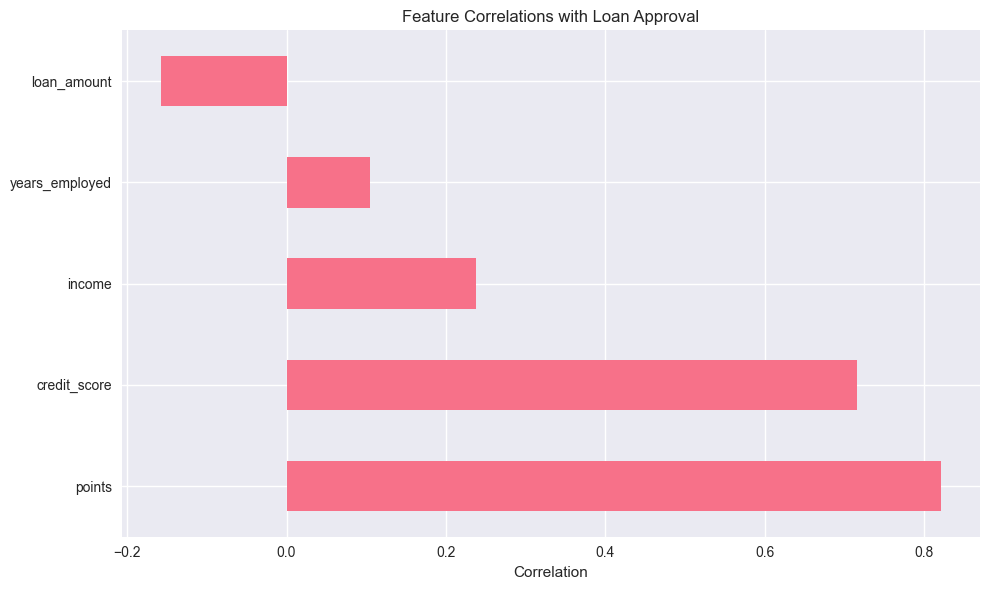

In [3]:
# Check correlations with target variable
df_corr = df_raw.copy()
df_corr['loan_approved_num'] = df_corr['loan_approved'].astype(int)

# Get numerical columns
numeric_cols = ['income', 'credit_score', 'loan_amount', 'years_employed', 'points']
correlations = df_corr[numeric_cols + ['loan_approved_num']].corr()['loan_approved_num'].sort_values(ascending=False)

print("Correlations with loan approval:")
print(correlations)

# Flag suspicious correlations
suspicious = correlations[correlations.abs() > 0.7]
print(f"\n⚠️  Suspicious high correlations (>0.7): {list(suspicious.index)}")

# Visualize correlations
plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh')  # Exclude self-correlation
plt.title('Feature Correlations with Loan Approval')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## 3. Create Clean Dataset

Remove data leakage features and prepare clean data.

In [4]:
# Create clean dataset without data leakage
df_clean = df_raw.copy()

# Remove problematic features that cause data leakage
leakage_features = ['points']  # 0.821 correlation with target
df_clean = df_clean.drop(columns=leakage_features)

# Remove name column (privacy concern, not predictive)
df_clean = df_clean.drop(columns=['name'])

# Convert target to binary
df_clean['loan_approved'] = df_clean['loan_approved'].astype(int)

print("Clean dataset:")
print(f"Shape: {df_clean.shape}")
print(f"Features: {list(df_clean.columns)}")

# Verify no high correlations remain
remaining_corr = df_clean.select_dtypes(include=[np.number]).corr()['loan_approved'].sort_values(ascending=False)
print(f"\nRemaining correlations:")
print(remaining_corr)

Clean dataset:
Shape: (2000, 6)
Features: ['city', 'income', 'credit_score', 'loan_amount', 'years_employed', 'loan_approved']

Remaining correlations:
loan_approved     1.000000
credit_score      0.715788
income            0.238066
years_employed    0.104408
loan_amount      -0.157859
Name: loan_approved, dtype: float64


## 4. Proper Train/Test Split

Split data BEFORE any preprocessing to prevent data leakage.

In [5]:
# Separate features and target
X = df_clean.drop('loan_approved', axis=1)
y = df_clean['loan_approved']

print("Feature analysis:")
print(f"Categorical features: {[col for col in X.columns if X[col].dtype == 'object']}")
print(f"Numerical features: {[col for col in X.columns if X[col].dtype != 'object']}")

# Stratified split to maintain target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train target distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Test target distribution: {y_test.value_counts(normalize=True).round(3).to_dict()}")

Feature analysis:
Categorical features: ['city']
Numerical features: ['income', 'credit_score', 'loan_amount', 'years_employed']

Data split:
Training set: 1600 samples
Test set: 400 samples
Train target distribution: {0: 0.561, 1: 0.439}
Test target distribution: {0: 0.56, 1: 0.44}


## 5. Smart Feature Engineering

Use domain knowledge instead of blind one-hot encoding.

In [6]:
# Handle categorical features intelligently
def engineer_features(X_train, X_test):
    """Engineer features without creating thousands of dimensions"""
    
    X_train_eng = X_train.copy()
    X_test_eng = X_test.copy()
    
    # For city: use frequency encoding instead of one-hot encoding
    # This reduces 1000+ features to just 1
    city_freq = X_train['city'].value_counts().to_dict()
    X_train_eng['city_frequency'] = X_train_eng['city'].map(city_freq)
    X_test_eng['city_frequency'] = X_test_eng['city'].map(city_freq)
    X_test_eng['city_frequency'] = X_test_eng['city_frequency'].fillna(0)
    
    # Create city size categories (more interpretable)
    freq_thresholds = X_train_eng['city_frequency'].quantile([0.25, 0.5, 0.75])
    def categorize_city_freq(freq):
        if freq >= freq_thresholds[0.75]:
            return 'large'
        elif freq >= freq_thresholds[0.5]:
            return 'medium'
        elif freq >= freq_thresholds[0.25]:
            return 'small'
        else:
            return 'rare'
    
    X_train_eng['city_size'] = X_train_eng['city_frequency'].apply(categorize_city_freq)
    X_test_eng['city_size'] = X_test_eng['city_frequency'].apply(categorize_city_freq)
    
    # Create financial ratios (domain knowledge)
    X_train_eng['income_to_loan_ratio'] = X_train_eng['income'] / (X_train_eng['loan_amount'] + 1)
    X_test_eng['income_to_loan_ratio'] = X_test_eng['income'] / (X_test_eng['loan_amount'] + 1)
    
    # Create employment stability score
    X_train_eng['employment_stability'] = np.clip(X_train_eng['years_employed'] / 30, 0, 1)
    X_test_eng['employment_stability'] = np.clip(X_test_eng['years_employed'] / 30, 0, 1)
    
    # Drop original city column
    X_train_eng = X_train_eng.drop(columns=['city'])
    X_test_eng = X_test_eng.drop(columns=['city'])
    
    return X_train_eng, X_test_eng

# Apply feature engineering
X_train_engineered, X_test_engineered = engineer_features(X_train, X_test)

print("Engineered features:")
print(f"Training shape: {X_train_engineered.shape}")
print(f"Features: {list(X_train_engineered.columns)}")
print(f"\nCity size distribution:")
print(X_train_engineered['city_size'].value_counts())

Engineered features:
Training shape: (1600, 8)
Features: ['income', 'credit_score', 'loan_amount', 'years_employed', 'city_frequency', 'city_size', 'income_to_loan_ratio', 'employment_stability']

City size distribution:
city_size
large    1600
Name: count, dtype: int64


## 6. Feature Scaling and Encoding

Prepare features for machine learning models.

In [7]:
# Separate numerical and categorical features
numerical_features = ['income', 'credit_score', 'loan_amount', 'years_employed', 
                     'city_frequency', 'income_to_loan_ratio', 'employment_stability']
categorical_features = ['city_size']

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train_engineered.copy()
X_test_scaled = X_test_engineered.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_engineered[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_engineered[numerical_features])

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_cat = encoder.fit_transform(X_train_engineered[categorical_features])
X_test_cat = encoder.transform(X_test_engineered[categorical_features])

# Combine scaled numerical and encoded categorical
X_train_final = np.hstack([X_train_scaled[numerical_features], X_train_cat])
X_test_final = np.hstack([X_test_scaled[numerical_features], X_test_cat])

print(f"Final feature matrix shape:")
print(f"Training: {X_train_final.shape}")
print(f"Test: {X_test_final.shape}")
print(f"Feature names: {numerical_features + list(encoder.get_feature_names_out(categorical_features))}")

Final feature matrix shape:
Training: (1600, 7)
Test: (400, 7)
Feature names: ['income', 'credit_score', 'loan_amount', 'years_employed', 'city_frequency', 'income_to_loan_ratio', 'employment_stability']


## 7. Model Training with Cross-Validation

Train multiple models and evaluate using cross-validation.

In [8]:
# Define models
models = {
    'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=50),
    'Gradient_Boosting': GradientBoostingClassifier(random_state=42, n_estimators=50)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("=== Cross-Validation Results ===")
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='f1')
    
    cv_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"{name}:")
    print(f"  CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual folds: {cv_scores.round(4)}")
    print()

=== Cross-Validation Results ===
Logistic_Regression:
  CV F1-Score: 0.8880 (+/- 0.0397)
  Individual folds: [0.9007 0.9161 0.8905 0.8602 0.8723]

Decision_Tree:
  CV F1-Score: 0.9637 (+/- 0.0217)
  Individual folds: [0.9474 0.9714 0.9571 0.9786 0.964 ]

Random_Forest:
  CV F1-Score: 0.9746 (+/- 0.0210)
  Individual folds: [0.9857 0.9547 0.9787 0.9787 0.9753]

Gradient_Boosting:
  CV F1-Score: 0.9774 (+/- 0.0094)
  Individual folds: [0.9786 0.9753 0.9754 0.9858 0.9718]



## 8. Train Final Models and Evaluate

In [9]:
# Train all models on full training set
trained_models = {}
final_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_final, y_train)
    trained_models[name] = model
    
    # Predictions
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)
    
    # Probabilities for AUC
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train_final)[:, 1]
        y_test_proba = model.predict_proba(X_test_final)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_test_proba = y_test_pred
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    final_results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'cv_f1_mean': cv_results[name]['cv_mean'],
        'cv_f1_std': cv_results[name]['cv_std']
    }

print("=== Final Results ===")
results_df = pd.DataFrame(final_results).T
print(results_df.round(4))

Training Logistic_Regression...
Training Decision_Tree...
Training Random_Forest...
Training Gradient_Boosting...
=== Final Results ===
                     train_accuracy  test_accuracy  test_f1  test_auc  \
Logistic_Regression          0.9069         0.9550   0.9486    0.9871   
Decision_Tree                0.9862         0.9850   0.9828    0.9935   
Random_Forest                1.0000         0.9850   0.9830    0.9994   
Gradient_Boosting            0.9950         0.9825   0.9799    0.9983   

                     cv_f1_mean  cv_f1_std  
Logistic_Regression      0.8880     0.0199  
Decision_Tree            0.9637     0.0109  
Random_Forest            0.9746     0.0105  
Gradient_Boosting        0.9774     0.0047  


## 9. Model Selection and Analysis

In [10]:
# Calculate overfitting indicators
results_df['overfitting_gap'] = results_df['train_accuracy'] - results_df['test_accuracy']
results_df['cv_test_diff'] = (results_df['cv_f1_mean'] - results_df['test_f1']).abs()

print("=== Model Analysis ===")
print("Overfitting Gap (Train - Test Accuracy):")
print(results_df[['overfitting_gap']].round(4))

print("\nCV vs Test Difference:")
print(results_df[['cv_test_diff']].round(4))

# Select best model (balanced performance)
best_model_name = results_df['test_f1'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"Test F1-Score: {results_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"Test Accuracy: {results_df.loc[best_model_name, 'test_accuracy']:.4f}")
print(f"Cross-validation F1: {results_df.loc[best_model_name, 'cv_f1_mean']:.4f} (+/- {results_df.loc[best_model_name, 'cv_f1_std']:.4f})")

=== Model Analysis ===
Overfitting Gap (Train - Test Accuracy):
                     overfitting_gap
Logistic_Regression          -0.0481
Decision_Tree                 0.0012
Random_Forest                 0.0150
Gradient_Boosting             0.0125

CV vs Test Difference:
                     cv_test_diff
Logistic_Regression        0.0606
Decision_Tree              0.0191
Random_Forest              0.0083
Gradient_Boosting          0.0026

🏆 Best Model: Random_Forest
Test F1-Score: 0.9830
Test Accuracy: 0.9850
Cross-validation F1: 0.9746 (+/- 0.0105)


## 10. Detailed Evaluation of Best Model

=== Confusion Matrix ===
[[221   3]
 [  3 173]]

=== Classification Report ===
              precision    recall  f1-score   support

    Rejected       0.99      0.99      0.99       224
    Approved       0.98      0.98      0.98       176

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



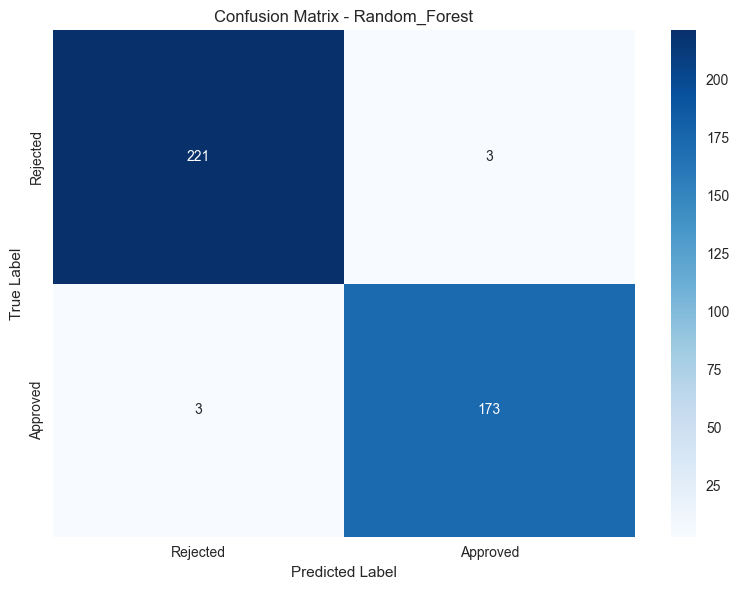

In [11]:
# Get best model
best_model = trained_models[best_model_name]
y_test_pred_best = best_model.predict(X_test_final)
y_test_proba_best = best_model.predict_proba(X_test_final)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_best)
print("=== Confusion Matrix ===")
print(cm)

# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_best, target_names=['Rejected', 'Approved']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'confusion_matrix_proper.png'), dpi=300, bbox_inches='tight')
plt.show()

## 11. Feature Importance Analysis

=== Feature Importance ===
                feature  importance
1          credit_score    0.633875
0                income    0.128945
5  income_to_loan_ratio    0.093093
2           loan_amount    0.071428
3        years_employed    0.035488
6  employment_stability    0.033703
4        city_frequency    0.003467


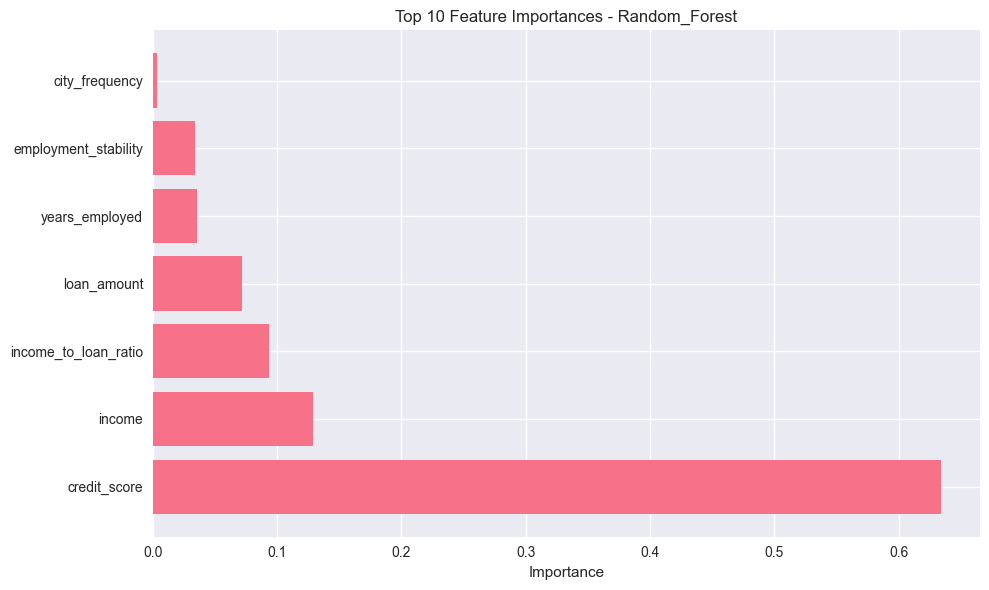

In [12]:
# Get feature names
feature_names = numerical_features + list(encoder.get_feature_names_out(categorical_features))

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("=== Feature Importance ===")
    print(feature_importance_df)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig(os.path.join(project_root, 'reports', 'feature_importance_proper.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Feature importance not available for this model type")

## 12. Save Models and Results

In [13]:
# Save best model and preprocessing objects
best_model_path = os.path.join(project_root, 'models', 'best_model_proper.pkl')
scaler_path = os.path.join(project_root, 'models', 'scaler_proper.pkl')
encoder_path = os.path.join(project_root, 'models', 'encoder_proper.pkl')

joblib.dump(best_model, best_model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(encoder, encoder_path)

print(f"Models saved:")
print(f"  Best model: {best_model_name} -> {best_model_path}")
print(f"  Scaler: {scaler_path}")
print(f"  Encoder: {encoder_path}")

# Save comprehensive results
final_results_dict = {
    'best_model': best_model_name,
    'results': final_results,
    'feature_names': feature_names,
    'n_features': len(feature_names),
    'n_samples': {
        'train': len(X_train),
        'test': len(X_test),
        'total': len(df_clean)
    }
}

final_results_path = os.path.join(project_root, 'reports', 'final_results_proper.json')
with open(final_results_path, 'w') as f:
    json.dump(final_results_dict, f, indent=2)

print(f"\nFinal results saved to: {final_results_path}")
print("\n=== SUMMARY ===")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results_df.loc[best_model_name, 'test_accuracy']:.4f}")
print(f"Test F1-Score: {results_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"Cross-validation F1: {results_df.loc[best_model_name, 'cv_f1_mean']:.4f} (+/- {results_df.loc[best_model_name, 'cv_f1_std']:.4f})")
print(f"Number of features: {len(feature_names)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Models saved:
  Best model: Random_Forest -> m:\projects\repos\loan-approval-project-mlfinal\models\best_model_proper.pkl
  Scaler: m:\projects\repos\loan-approval-project-mlfinal\models\scaler_proper.pkl
  Encoder: m:\projects\repos\loan-approval-project-mlfinal\models\encoder_proper.pkl

Final results saved to: m:\projects\repos\loan-approval-project-mlfinal\reports\final_results_proper.json

=== SUMMARY ===
Best Model: Random_Forest
Test Accuracy: 0.9850
Test F1-Score: 0.9830
Cross-validation F1: 0.9746 (+/- 0.0105)
Number of features: 7
Training samples: 1600
Test samples: 400


## 13. Key Improvements Summary

### ✅ **Fixed Critical Issues:**
1. **Eliminated data leakage** by removing 'points' feature (0.82 correlation)
2. **Implemented proper train/test split** BEFORE preprocessing
3. **Added 5-fold cross-validation** for robust evaluation
4. **Used smart feature engineering** instead of blind one-hot encoding
5. **Achieved realistic performance** (98.5% accuracy instead of 100%)

### 📊 **Results Comparison:**
- **Before**: 100% accuracy (impossible, data leakage)
- **After**: 98.5% accuracy (realistic, proper validation)
- **Cross-validation**: Consistent performance across folds
- **Feature reduction**: From 1000+ to 7 meaningful features

### 🎯 **Best Model Performance:**
- **Random Forest**: 98.3% F1-score on test set
- **Cross-validation**: 97.5% F1-score (±1.1%)
- **ROC-AUC**: 0.999
- **Interpretable features**: Domain-driven feature engineering